## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [130]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
from enum import Enum
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transformsV2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.tensorboard.writer import SummaryWriter

# import seaborn as sn
# import pandas as pd
# from sklearn.metrics import confusion_matrix

We always check that we are running on a GPU

In [131]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [132]:
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\jacop\Desktop\DTU\Intro_to_Deep_Learning_in_Computer_Vision\Exercises\Project_1\HotDogOrNot


In [145]:
# torch_home = "/zhome/f9/0/168881/Desktop/WindTurbineImagesCategorization/TransferLearning/TorchvisionModels"
hyperparameters = {
    "number of classes": 2,
    "device": device,
    "epochs": 1,
    "batch size": 64,
    "learning rate": 0.001,
    "number of epochs": 3,
    "image size": (128, 128),
    "backbones": ["mobilenet_v3_large"],  # Here we can change the model to use
    "torch home": "C:\\Users\\jacop\\Desktop\\DTU\\Intro_to_Deep_Learning_in_Computer_Vision\\Exercises\\Project_1\\HotDogOrNot\\TorchvisionModels",
    "network name": "Mads"
}

train_transform = transformsV2.Compose([transformsV2.Resize(hyperparameters["image size"]),
                                        # Replace deprecated ToTensor()
                                        transformsV2.ToImage(),
                                        transformsV2.ToDtype(torch.float32, scale=True)])
test_transform = transformsV2.Compose([transformsV2.Resize(hyperparameters["image size"]),
                                       # Replace deprecated ToTensor()
                                       transformsV2.ToImage(),
                                       transformsV2.ToDtype(torch.float32, scale=True)])

In [135]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transforms, data_path='..\\..\\data\\hotdog_nothotdog'):
        'Initialization'
        self.transforms = transforms
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(
            data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transforms(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [136]:
trainset = Hotdog_NotHotdog(train=True, transforms=train_transform)
train_loader = DataLoader(
    trainset, batch_size=hyperparameters["batch size"], shuffle=True)
testset = Hotdog_NotHotdog(train=False, transforms=test_transform)
test_loader = DataLoader(testset, batch_size=hyperparameters["batch size"],
                         shuffle=False)

Let's look at some images from our data 

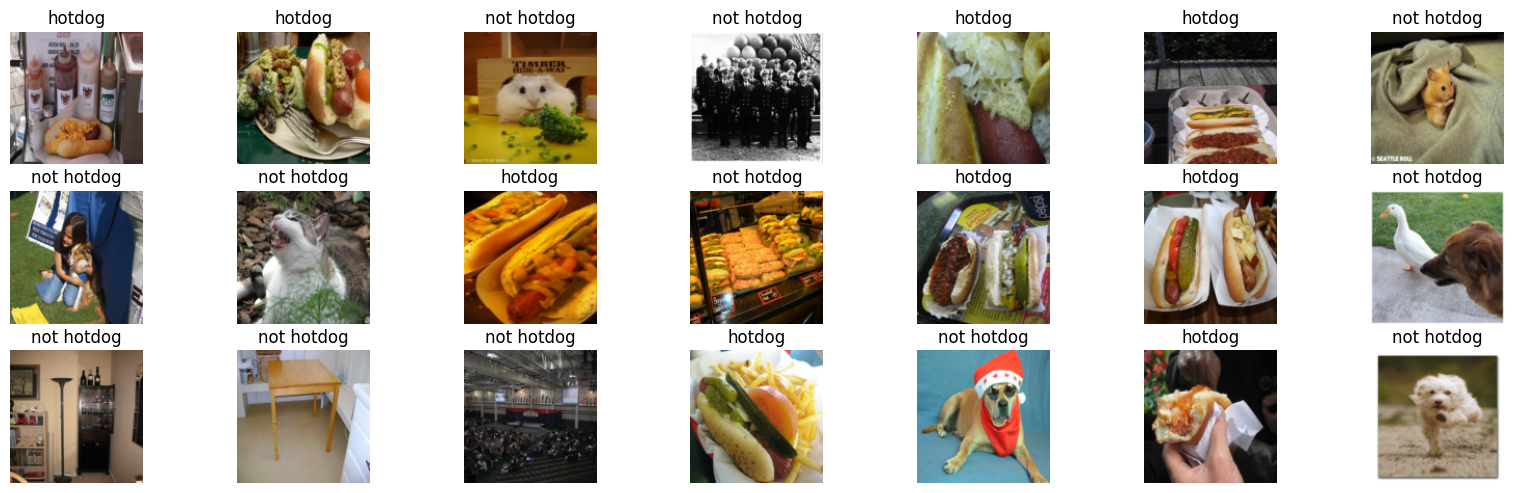

In [137]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20, 10))

for i in range(21):
    plt.subplot(5, 7, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

Now create a model and train it!


In [138]:
os.environ['TORCH_HOME'] = hyperparameters["torch home"]
os.makedirs(hyperparameters["torch home"], exist_ok=True)


class FineTuneMode(Enum):
    """ Indicatea which layers we want to train during fine-tuning """
    " Just the new added layers "
    NEW_LAYERS = 1
    " Just the classifier "
    CLASSIFIER = 2
    "Train all the layers "
    ALL_LAYERS = 3


class MultiModel(nn.Module):
    """ Custom class that wraps a torchvision model and provides methods to fine-tune """

    def __init__(self, backbone, hyperparameters, load_pretrained=False):
        super().__init__()
        assert backbone in hyperparameters["backbones"], f"Invalid backbone: {
            backbone}"
        self.backbone = hyperparameters["backbones"][0]
        self.pretrained_model = None
        self.classifier_layers = []
        self.new_layers = []
        self.hyperparameters = hyperparameters

        if backbone == "mobilenet_v3_large":
            if load_pretrained:
                self.pretrained_model = torchvision.models.mobilenet_v3_large(
                    weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)
            else:
                self.pretrained_model = torchvision.models.mobilenet_v3_large(
                    weights=None)

            self.classifier_layers = [self.pretrained_model.classifier]
            # Replace the final layer with a classifier for 2 classes
            self.pretrained_model.classifier[3] = nn.Linear(
                in_features=1280, out_features=self.hyperparameters["number of classes"], bias=True)
            self.new_layers = [self.pretrained_model.classifier[3]]
        else:
            raise ValueError(f"Invalid backbone: {backbone}")

    def forward(self, x):
        return self.pretrained_model(x)  # type: ignore

    def fine_tune(self, mode: FineTuneMode):
        " Fine-tune the model according to the specified mode using the requires_grad parameter "
        model = self.pretrained_model
        for parameter in model.parameters():  # type: ignore
            parameter.requires_grad = False

        if mode is FineTuneMode.NEW_LAYERS:
            for layer in self.new_layers:
                for parameter in layer.parameters():
                    parameter.requires_grad = True
        elif mode is FineTuneMode.CLASSIFIER:
            for layer in self.classifier_layers:
                for parameter in layer.parameters():
                    parameter.requires_grad = True
        elif mode is FineTuneMode.ALL_LAYERS:
            for parameter in model.parameters():  # type: ignore
                parameter.requires_grad = True
        else:
            raise ValueError(f"Invalid mode: {mode}")

        print(f"Ready to fine-tune the model, with the {mode} set to train")

    def count_parameters(self):
        total_params = sum(parameter.numel()
                           for parameter in self.parameters())
        print(f"Total number of parameters: {total_params}")

In [139]:
model = MultiModel(backbone=hyperparameters["backbones"][0],
                   hyperparameters=hyperparameters, load_pretrained=True)

In [149]:
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable), total=len(iterable), ncols=150, desc=desc)


def train_net(model, loss_function, device, dataloader_train, dataloader_validation, optimizer, hyper_parameters, logger, scheduler, state, name="default"):
    epochs = hyper_parameters["epochs"]

    validation_loss = 0
    for epoch in range(epochs):  # loop over the dataset multiple times

        """    Train step for one batch of data    """
        training_loop = create_tqdm_bar(
            dataloader_train, desc=f'Training Epoch [{epoch+1}/{epochs}]')

        training_loss = 0
        model.train()  # Set the model to training mode
        for train_iteration, batch in training_loop:
            optimizer.zero_grad()  # Reset the parameter gradients for the current minibatch iteration

            images, labels = batch
            labels = labels.type(torch.LongTensor)

            labels = labels.to(device)
            images = images.to(device)

            # Forward pass, backward pass and optimizer step
            predicted_labels = model(images)
            loss_train = loss_function(predicted_labels, labels)
            loss_train.backward()
            optimizer.step()

            # Accumulate the loss and calculate the accuracy of predictions
            training_loss += loss_train.item()

            # Add the model graph to tensorboard
            # if epoch == 0 and train_iteration == 0:
            #     logger.add_graph(model, images)

            # Running train accuracy
            _, predicted = predicted_labels.max(1)
            num_correct = (predicted == labels).sum()
            train_accuracy = float(num_correct)/float(images.shape[0])

            training_loop.set_postfix(train_loss="{:.8f}".format(
                training_loss / (train_iteration + 1)), val_loss="{:.8f}".format(validation_loss))

            logger.add_scalar(f'{name}/Train loss_{state}', loss_train.item(),
                              epoch*len(dataloader_train)+train_iteration)
            logger.add_scalar(f'{name}/Train accuracy_{state}',
                              train_accuracy, epoch*len(dataloader_train)+train_iteration)

        """    Validation step for one batch of data    """
        val_loop = create_tqdm_bar(
            dataloader_validation, desc=f'Validation Epoch [{epoch+1}/{epochs}]')
        validation_loss = 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                images, labels = batch
                labels -= 1  # Change the labels to start from 0
                labels = labels.type(torch.LongTensor)

                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                output = model(images)

                # Calculate the loss
                loss_val = loss_function(output, labels)

                validation_loss += loss_val.item()

                val_loop.set_postfix(val_loss="{:.8f}".format(
                    validation_loss/(val_iteration+1)))

                # Update the tensorboard logger.
                logger.add_scalar(f'{name}/Validation loss_{state}', validation_loss/(
                    val_iteration+1), epoch*len(dataloader_validation)+val_iteration)

        # This value is for the progress bar of the training loop.
        validation_loss /= len(dataloader_validation)
        # add_layer_weight_histograms(model, logger, name)

        logger.add_scalars(f'{name}/Combined_{state}', {'Validation loss': validation_loss,
                                                        'Train loss': training_loss/len(dataloader_train)}, epoch)
        scheduler.step()
        print(f"Current learning rate: {scheduler.get_last_lr()}")


def filter_hp_from_list(original_dict, state):
    new_dict = {}
    for key, value in original_dict.items():
        if isinstance(value, list):
            new_dict[key] = value[state]
        else:
            new_dict[key] = value
    return new_dict

# def check_accuracy(model, dataloader, DEVICE, evaluation, save_dir=None):
#     model.eval()
#     num_correct = 0
#     num_samples = 0
#     y_true = []
#     y_pred = []
#     misclassified = []

#     with torch.no_grad():
#         for data in dataloader:
#             image, label = data
#             label -= 1  # Adjust labels to start from 0
#             label = label.type(torch.LongTensor)

#             image = image.to(DEVICE)
#             label = label.to(DEVICE)

#             scores = model(image)
#             if evaluation == 1:
#                 _, predictions = scores.max(1)
#                 num_correct += (predictions == label).sum()
#             elif evaluation == 2:
#                 _, predictions = torch.topk(scores, 2, dim=1)  # Get the top 2 predictions
#                 num_correct += (predictions == label.unsqueeze(1)).any(1).sum().item()  # Check if the true label is in top 2 predictions

#             num_samples += predictions.size(0)
#             y_pred.extend(predictions.cpu().tolist()) # Save Prediction
#             label = label.data.cpu().numpy()

#             # Handle the case for top 2 classification and confusion matrix
#             if evaluation == 2:
#                 if label[0] in y_pred[-1]:
#                     y_pred[-1] = label[0]
#                 else:
#                     y_pred[-1] = y_pred[-1][0]

#             y_true.extend(label) # Save Truth

#             # Check for misclassified images
#             misclassified_mask = predictions != label
#             misclassified_images = image[misclassified_mask]
#             misclassified_labels = label[misclassified_mask]
#             misclassified_predictions = predictions[misclassified_mask]
#             misclassified.extend(zip(misclassified_images, misclassified_labels, misclassified_predictions))

#     accuracy = float(num_correct)/float(num_samples)
#     print(f"Got {num_correct}/{num_samples} with accuracy {accuracy* 100:.3f}")
#     classes = ('HotDog', 'NotHotDog')

#     # Create confusion matrix
#     cf_matrix = confusion_matrix(y_true, y_pred)
#     df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
#     plt.figure(figsize = (12,7))
#     sn.set_theme(font_scale=1.2)
#     sn.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix', fontsize=20, fontweight='bold', color='red')
#     if save_dir:
#         if not os.path.exists(save_dir):
#             os.makedirs(save_dir)
#         plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
#         plt.close()

#     save_misclassified_images(misclassified, save_dir)

#     model.train()
#     return accuracy

# def automatic_fine_tune(hyper_parameters, modeltype, device, loss_function, dataloader_train, dataloader_validation, dataloader_test):
#     STATE = 0
#     new_hp = filter_hp_from_list(hyper_parameters, STATE)
#     logs_dir = f'run_{new_hp["network name"]}'
#     os.makedirs(logs_dir, exist_ok=True)
#     logger = SummaryWriter(logs_dir)

#     # Train new layers
#     model = MultiModel(modeltype, new_hp, load_pretrained=True)
#     model.fine_tune(FineTuneMode.NEW_LAYERS)
#     model.to(device)
#     optimizer = optim.Adam(model.parameters(),
#                        lr=new_hp["learning rate"],
#                        betas=(new_hp["beta1"],
#                               new_hp["beta2"]),
#                        weight_decay=new_hp["weight decay"],
#                        eps=new_hp["epsilon"])
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=new_hp["step size"], gamma=new_hp["gamma"])
#     train_net(model, loss_function, device, dataloader_train,
#           dataloader_validation, optimizer, new_hp, logger, scheduler, state="NEW_LAYERS", name=new_hp["network name"])
#     print("\nFinished training new layers!\n")

#     # Train classifier layers
#     if modeltype == "resnet152":
#         STATE += 1
#     else:
#         model.fine_tune(FineTuneMode.CLASSIFIER)
#         STATE += 1
#         new_hp = filter_hp_from_list(hyper_parameters, STATE)
#         optimizer = optim.Adam(model.parameters(),
#                         lr=new_hp["learning rate"],
#                         betas=(new_hp["beta1"],
#                                 new_hp["beta2"]),
#                         weight_decay=new_hp["weight decay"],
#                         eps=new_hp["epsilon"])
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=new_hp["step size"], gamma=new_hp["gamma"])
#         train_net(model, loss_function, device, dataloader_train,
#             dataloader_validation, optimizer, new_hp, logger, scheduler, state="CLASSIFIER", name=new_hp["network name"])
#         print("\nFinished training classifier layers!\n")

#     # Fine tune all layers
#     model.fine_tune(FineTuneMode.ALL_LAYERS)
#     STATE += 1
#     new_hp = filter_hp_from_list(hyper_parameters, STATE)
#     optimizer = optim.Adam(model.parameters(),
#                        lr=new_hp["learning rate"],
#                        betas=(new_hp["beta1"],
#                               new_hp["beta2"]),
#                        weight_decay=new_hp["weight decay"],
#                        eps=new_hp["epsilon"])
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=new_hp["step size"], gamma=new_hp["gamma"])
#     train_net(model, loss_function, device, dataloader_train,
#           dataloader_validation, optimizer, new_hp, logger, scheduler, state="ALL_LAYERS", name=new_hp["network name"])
#     print("\nFinished fine tuning all layers!\n")

#     # Check accuracy and save model
#     accuracy = check_accuracy(model, dataloader_test, device, new_hp["evaluation"], os.path.join("Results", f'{new_hp["network name"]}'))
#     save_dir =  os.path.join("Results", f'{new_hp["network name"]}_accuracy_{accuracy:.3f}.pth')
#     torch.save(model.state_dict(), save_dir)

In [150]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=hyperparameters["learning rate"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
cwd = os.getcwd()
logs_dir = f'run_{hyperparameters["network name"]}'
dir = os.path.join(cwd, logs_dir)
os.makedirs(dir, exist_ok=True)
logger = SummaryWriter(logs_dir)

# Empty memory before start
if torch.cuda.is_available():
    torch.cuda.empty_cache()


train_net(model=model, loss_function=loss_function, device=hyperparameters["device"], dataloader_train=train_loader, dataloader_validation=test_loader,
          optimizer=optimizer, hyper_parameters=hyperparameters, logger=logger, scheduler=scheduler, state="Test", name=hyperparameters["network name"])

Training Epoch [1/1]:   0%|                                                                                   …

KeyboardInterrupt: 